In [1]:
import sys

# Core packages for training and evaluation

!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install "numpy<2"


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#  Check GPU
print("GPU available:", tf.config.list_physical_devices('GPU'))



GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#  Directory & image settings
data_dir = 'Datasets'
img_size = 224
batch_size = 16

#  Enhanced ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [4]:
#  Load MobileNet base
base_model = tf.keras.applications.MobileNet(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

#  Build model with extra Dropout and Dense layer
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(128, activation='relu'),  # Extra Dense layer
    layers.Dropout(0.3),  # Extra Dropout layer
    layers.Dense(1, activation='sigmoid')
])



In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                        

In [7]:
#  Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "eye_state_model3.keras", save_best_only=True, monitor='val_accuracy'
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True, monitor='val_loss'
)


In [8]:

#  Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Use higher value with early stopping
    callbacks=[checkpoint_cb, early_stopping_cb]
)



Epoch 1/30
2400/2400 [==============================] - 689s 284ms/step - loss: 0.1350 - accuracy: 0.9482 - val_loss: 0.3548 - val_accuracy: 0.9030
Epoch 2/30
2400/2400 [==============================] - 689s 284ms/step - loss: 0.1350 - accuracy: 0.9482 - val_loss: 0.3548 - val_accuracy: 0.9030
Epoch 2/30
2400/2400 [==============================] - 463s 193ms/step - loss: 0.0894 - accuracy: 0.9683 - val_loss: 0.3442 - val_accuracy: 0.8983
Epoch 3/30
2400/2400 [==============================] - 463s 193ms/step - loss: 0.0894 - accuracy: 0.9683 - val_loss: 0.3442 - val_accuracy: 0.8983
Epoch 3/30
2400/2400 [==============================] - 336s 140ms/step - loss: 0.0806 - accuracy: 0.9698 - val_loss: 0.3162 - val_accuracy: 0.9060
Epoch 4/30
Epoch 4/30
2400/2400 [==============================] - 347s 145ms/step - loss: 0.0775 - accuracy: 0.9723 - val_loss: 0.4018 - val_accuracy: 0.8926
Epoch 5/30
Epoch 5/30
2400/2400 [==============================] - 347s 145ms/step - loss: 0.0761 - a

In [9]:
#  Save final model
model.save('final_eye_state_model3.keras')



# ========================
#  Evaluation & Plots
# ========================

In [10]:


# Get true and predicted labels
y_true = val_generator.classes
pred_probs = model.predict(val_generator)
y_pred = (pred_probs > 0.5).astype("int32").reshape(-1)


600/600 [==============================] - 67s 111ms/step


In [11]:

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())



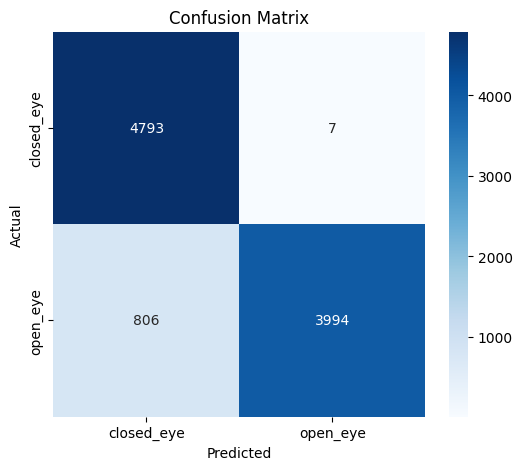

In [12]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:

# ✅ Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))




Classification Report:
              precision    recall  f1-score   support

  closed_eye       0.86      1.00      0.92      4800
    open_eye       1.00      0.83      0.91      4800

    accuracy                           0.92      9600
   macro avg       0.93      0.92      0.91      9600
weighted avg       0.93      0.92      0.91      9600



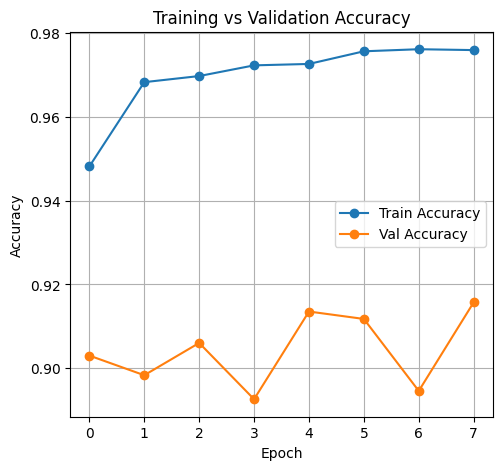

In [14]:
# ✅ Accuracy & Loss Plots
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)



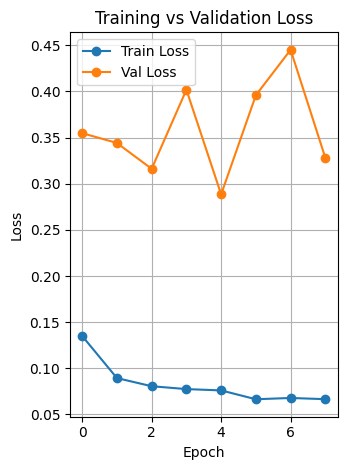

In [15]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# (Optional) Fine-tune more layers of MobileNet
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/20
2400/2400 [==============================] - 357s 147ms/step - loss: 0.4323 - accuracy: 0.9427 - val_loss: 0.3815 - val_accuracy: 0.9397
Epoch 2/20
2400/2400 [==============================] - 357s 147ms/step - loss: 0.4323 - accuracy: 0.9427 - val_loss: 0.3815 - val_accuracy: 0.9397
Epoch 2/20
2400/2400 [==============================] - 408s 170ms/step - loss: 0.1097 - accuracy: 0.9768 - val_loss: 0.3513 - val_accuracy: 0.9382
Epoch 3/20
2400/2400 [==============================] - 408s 170ms/step - loss: 0.1097 - accuracy: 0.9768 - val_loss: 0.3513 - val_accuracy: 0.9382
Epoch 3/20
2400/2400 [==============================] - 581s 242ms/step - loss: 0.0632 - accuracy: 0.9825 - val_loss: 0.3704 - val_accuracy: 0.9377
Epoch 4/20
2400/2400 [==============================] - 581s 242ms/step - loss: 0.0632 - accuracy: 0.9825 - val_loss: 0.3704 - val_accuracy: 0.9377
Epoch 4/20
2400/2400 [==============================] - 473s 197ms/step - loss: 0.0474 - accuracy: 0.9862 - val_

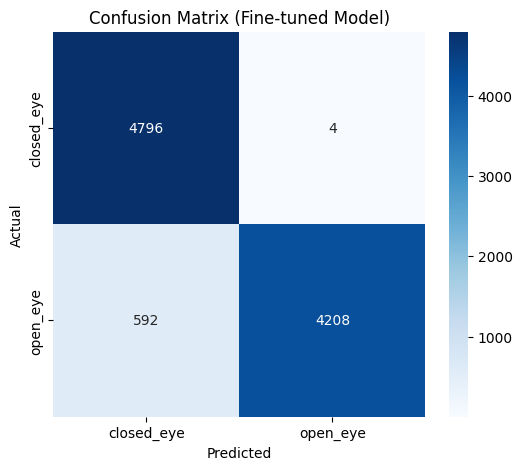

In [16]:
# Fine-tune the model after unfreezing layers
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Save the fine-tuned model
model.save('final_eye_state_model_finetuned2.keras')

# Evaluate fine-tuned model
# Get true and predicted labels
y_true_ft = val_generator.classes
pred_probs_ft = model.predict(val_generator)
y_pred_ft = (pred_probs_ft > 0.5).astype("int32").reshape(-1)

# Confusion Matrix for fine-tuned model
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)
labels_ft = list(val_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_ft, yticklabels=labels_ft)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Fine-tuned Model)')
plt.show()
